In [1]:
#Importing the libraries

#Remnants of some debugging...
import sys
from jupyter_core.paths import jupyter_data_dir

#Now here are the libraries
import numpy as np
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")
import warnings
warnings.filterwarnings('ignore')

#Splitting the dataset into test and train sets
dataset= pd.read_csv('/Users/chidinmaumenwofor-nweze/Desktop/zomato-restaurants-data/zomato.csv')
dataset['split'] = np.random.randn(dataset.shape[0], 1)
msk = np.random.rand(len(dataset)) <= 0.7

train = dataset[msk]
test = dataset[~msk]


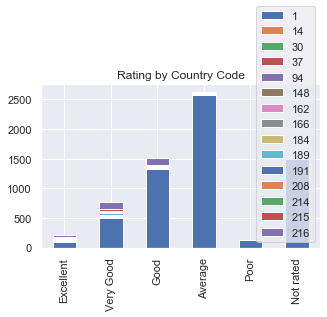

In [2]:
#PART ONE: DATA EXPLORATION AND VISUALISATION 

#Displaying the ratings of restaurants by country code
excellent_rating = train[train['Rating text']=='Excellent']['Country Code'].value_counts()
very_good_rating = train[train['Rating text']=='Very Good']['Country Code'].value_counts()
good_rating = train[train['Rating text']=='Good']['Country Code'].value_counts()
average_rating = train[train['Rating text']=='Average']['Country Code'].value_counts()
poor_rating = train[train['Rating text']=='Poor']['Country Code'].value_counts()
not_rated_rating = train[train['Rating text']=='Not rated']['Country Code'].value_counts()

df_rating = pd.DataFrame([excellent_rating,very_good_rating,good_rating,average_rating, poor_rating,not_rated_rating])
df_rating.index = ['Excellent','Very Good','Good','Average','Poor','Not rated']
df_rating.plot(kind='bar',stacked=True, figsize=(5,3), title="Rating by Country Code")

#By the looks of the bar chart the majority of the data is coming from India (country code 1).
#This makes sense as Zomato is an Indian Service.
#Therefore, it is important to note my model would probably work best on restaurant data 
#from India, as the training set is primarily made up of such data points.
#Furthermore, a large quantity of the restaurants are not rated. So I may have to fill in this data.





Percentage of restaurants not rated = 22.0 %


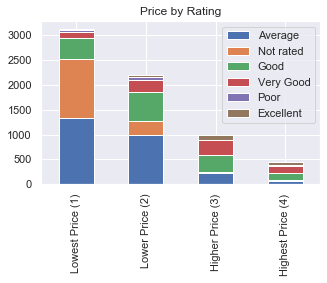

In [3]:
#Calculating the percentage of restaurants that were not rated:

#1. Total number of restaurants not rated in the training set
Number_of_restaurants_nr= df_rating.loc['Not rated'].sum()

#2. Total number of restaurants in both training and testing
with open('/Users/chidinmaumenwofor-nweze/Desktop/zomato-restaurants-data/zomato.csv') as f:
    total_row_count = sum(1 for row in f)
#3. Brute force calculation of the number of restaurants in the training set; 
#I couldn't figure out how to use pandas for this
number_of_restaurants_train= total_row_count * 0.7
#4. Finally, calculating and outputting the percentage
Percentage_nr = (Number_of_restaurants_nr/number_of_restaurants_train)*100
print("Percentage of restaurants not rated =" ,round(Percentage_nr),"%")

#23.0% is too large of an amount of data to delete and it shouldn't be ignored as it would reduce the model's predictive power. 
#I will look for correlations between other features (such as price) and the ratings
#to see if I can fill these not rated entries in by similar case imputation.

#Displaying the ratings of the restaurants by price range (4 is high; 1 is low)
lowest_price = train[train['Price range']== 1]['Rating text'].value_counts()
lower_price = train[train['Price range']== 2]['Rating text'].value_counts()
higher_price = train[train['Price range']== 3]['Rating text'].value_counts()
highest_price = train[train['Price range']== 4]['Rating text'].value_counts()

df_price_by_rating = pd.DataFrame([lowest_price,lower_price,higher_price,highest_price])
df_price_by_rating.index = ['Lowest Price (1)','Lower Price (2)','Higher Price (3)','Highest Price (4)']
df_price_by_rating.plot(kind='bar',stacked=True, figsize=(5,3), title="Price by Rating")

#From this chart we can see that lower priced food is often not rated. 
#Therefore, by similar case imputation, I can replace the 'not rated' 
#with the average rating of lower priced food.
#It is also interesting to note that lower priced food is considered average for the most part, 
#while more expensive food is rated more highly
#Expensive food seems rarer than low cost food.

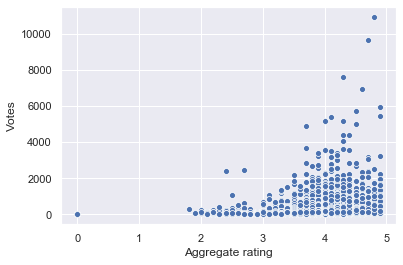

In [4]:
#Displaying the ratings of the restaurants by popularity (number of votes)

sns.scatterplot(x='Aggregate rating',y='Votes',data=train)

#As expected, the top-rated restaurants also have the most votes. 
#So popularity is correlated with a high rating.

In [5]:
#PART TWO: DATA CLEANING, FEATURE SELECTION (AND FEATURE ENGINEERING?)

#The dataset is already pretty clean in terms of the features I am focusing on. 
#However, there are many unneeded features that I will drop.

X = train.drop(['Restaurant ID','Restaurant Name','Country Code','City', 'Address', 'Locality', 'Locality Verbose','Longitude','Latitude','Cuisines','Average Cost for two','Currency','Has Table booking','Has Online delivery','Is delivering now','Switch to order menu','Rating color'], axis=1)
y = X['Rating text']                       
X=X.drop(['Rating text'], axis=1)       #remove the dependent variable (Rating text) from the dataframe X

X.head(5)

,Price range,Aggregate rating,Votes,split
0,3,4.8,314,2.041227
1,3,4.5,591,0.104378
2,4,4.4,270,-0.001314
4,4,4.8,229,1.491370
7,4,4.2,677,-0.166734


3.244758478931141
3.3801665799062985
3.429713248966284
0       Excellent
1       Excellent
2       Very Good
4       Excellent
7       Very Good
          ...    
9546    Very Good
9547    Very Good
9548         Good
9549    Very Good
9550    Very Good
Name: Rating text, Length: 6763, dtype: object


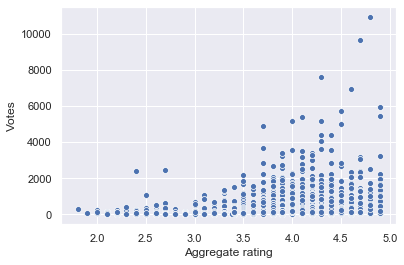

In [6]:
#Next, all the restaurants that are not rated, will be given a rating based on their price range.

#First the lowest priced restaurants that are not rated
mean_lowest_price = X[X['Price range']== 1]['Aggregate rating'].replace(0.0, np.nan).mean()
print(mean_lowest_price)

X[X['Price range']== 1]['Aggregate rating'].replace(0.0, np.nan, inplace=True)
X['Aggregate rating'].replace(np.nan, mean_lowest_price, inplace=True)

#Next the lower priced restaurants that are not rated
mean_lower_price = X[X['Price range']== 2]['Aggregate rating'].replace(0, np.nan).mean()
print(mean_lower_price)

X['Aggregate rating'].replace(0, mean_lower_price, inplace=True)

#Checking
print(X['Aggregate rating'].mean())

#This value seems about right as previously it was 2.66.
#However, I struggled with the syntax of the replacement method, so I have doubts.
#Checking the new scatterplot, no restaurant has a rating of 0 now.
sns.scatterplot(x='Aggregate rating',y='Votes',data=X)

#As an aggregate rating of 2.5-3.5 translates to a rating of "Average", the "Not Rated"
#text can be replaced with "Average" in the dependent variable.

y.replace('Not rated','Average', inplace=True)


In [7]:
#As we know, the 'Rating Text' is given as a string. 
#This needs to be encoded into numeric data so that the algorithm can perform calculations.
#This can be done easily using the LabelEncoder tool from sklearn.

n_rows = y.shape[0]

from sklearn.preprocessing import LabelEncoder
labelEncoder_X = LabelEncoder()
y=labelEncoder_X.fit_transform(y)

#Double-checking
print(y[0:20])
print(train['Rating text'][0:20])
#Shows that excellent = 1, very good = 4, good = 2, average = 0, and assuming poor = 3.

[1 1 4 1 4 1 1 1 4 1 4 2 4 1 1 4 1 1 0 2]
0     Excellent
1     Excellent
2     Very Good
4     Excellent
7     Very Good
8     Excellent
9     Excellent
10    Excellent
11    Very Good
12    Excellent
14    Very Good
15         Good
16    Very Good
17    Excellent
18    Excellent
19    Very Good
20    Excellent
21    Excellent
22      Average
23         Good
Name: Rating text, dtype: object


In [8]:
#PART THREE: TESTING DIFFERENT CLASSIFIERS

#Having preprocessed the data, I can now provide the data to different classifiers 
#and see which one performs better in creating a model of classification for this data.
#I will do this using cross-validation. Python has the cross_val_score class from the 
#sklearn.model_selection library to perform cross validation.

#-----------------------Logistic Regression---------------------------------------------
# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(penalty='l2',random_state = 0)

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X=X , y=y , cv = 10)
print("Logistic Regression:\n Accuracy:", accuracies.mean(), "+/-", accuracies.std(),"\n")

#-----------------------------------K-NN --------------------------------------------------

# Fitting K-NN to the Training set
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 9, metric = 'minkowski', p = 2)


# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X=X , y=y , cv = 10)
print("K-NN:\n Accuracy:", accuracies.mean(), "+/-", accuracies.std(),"\n")

#---------------------------------------SVM -------------------------------------------------

# Fitting Kernel SVM to the Training set
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X=X , y=y , cv = 10)
print("SVM:\n Accuracy:", accuracies.mean(), "+/-", accuracies.std(),"\n")

#---------------------------------Naive Bayes-------------------------------------------

# Fitting Naive Bayes to the Training set
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X=X , y=y , cv = 10)
print("Naive Bayes:\n Accuracy:", accuracies.mean(), "+/-", accuracies.std(),"\n")

#----------------------------Random Forest------------------------------------------

# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X=X , y=y , cv = 10)
print("Random Forest:\n Accuracy:", accuracies.mean(), "+/-", accuracies.std())


Logistic Regression:
 Accuracy: 0.6772191534178809 +/- 0.019959758046010457 

K-NN:
 Accuracy: 0.7121135710102873 +/- 0.01823261277568204 

SVM:
 Accuracy: 0.7064911767019482 +/- 0.02053738549095599 

Naive Bayes:
 Accuracy: 0.8979698548241896 +/- 0.016953761203403098 

Random Forest:
 Accuracy: 1.0 +/- 0.0


In [9]:
#PART THREE: CONCLUSIONS

#Impressively, Random Forest was the best model and achieved an accuracy of 100%. 
#I am very skeptical of this, and I'm concerned about overfitting.
#Therefore, I will go over the math for each of these models and try to learn more about them.

#Naive Bayes was a close 2nd place with a maximum of 92% accuracy, while the other models scored in the
#low 70s and high 60s.

#In general, this can be a helpful tool for foodies like me to find tasty food, even if it is not rated.
#Generally, I found low-cost, popular restaurants give the best experience when ordering on Zomato.
#Furthermore, this may be an interesting tool for Zomato to recommend lesser-rated restaurants
#to customers, while ensuring the customer still has an enjoyable experience. It can thus influence
#small businesses and little known restaurants to partner with Zomato, knowing they can get new 
#customers through a recommendation system.